In [110]:
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_groq import ChatGroq

from pprint import pprint
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import display, Image
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen-2.5-32b")

In [111]:
## define tools and bind with llm
def add(a:int,b:int)->int:
    """
    add a to b
    """
    return a+b

def multiply(a:int,b:int)->int:
    """
    Multiply a to b
    """
    return a*b

def divide(a:int,b:int)->int:
    """
    Divide a by b
    """
    return a/b

tools=[add, multiply, divide]
llm_with_tools=llm.bind_tools(tools)

In [112]:
sys_msg=SystemMessage(content='You are a helpfull assistant tasked with preforming arthmetic on a set of inputs.')

def assistant(state:MessagesState):
    return {'messages':[llm_with_tools.invoke([sys_msg]+state['messages'])]}

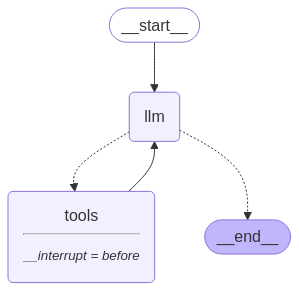

In [113]:
## Memory in Agents using MemorySaver
memory=MemorySaver()

## Graph
builder=StateGraph(MessagesState)
builder.add_node("llm",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm")
builder.add_conditional_edges(
    "llm",
    ## If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    ## IF the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","llm")
## Human in the loop
tool_graph=builder.compile(interrupt_before=["tools"], checkpointer=memory)

## display
display(Image(tool_graph.get_graph().draw_mermaid_png()))

In [114]:
intial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config={'configurable':{'thread_id':'1'}}

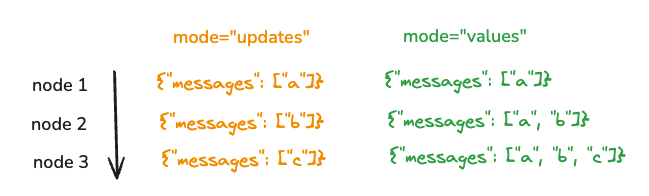

In [115]:
for event in tool_graph.stream(intial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_atq4)
 Call ID: call_atq4
  Args:
    a: 2
    b: 3


In [116]:
state = tool_graph.get_state(config)
state.next

('tools',)

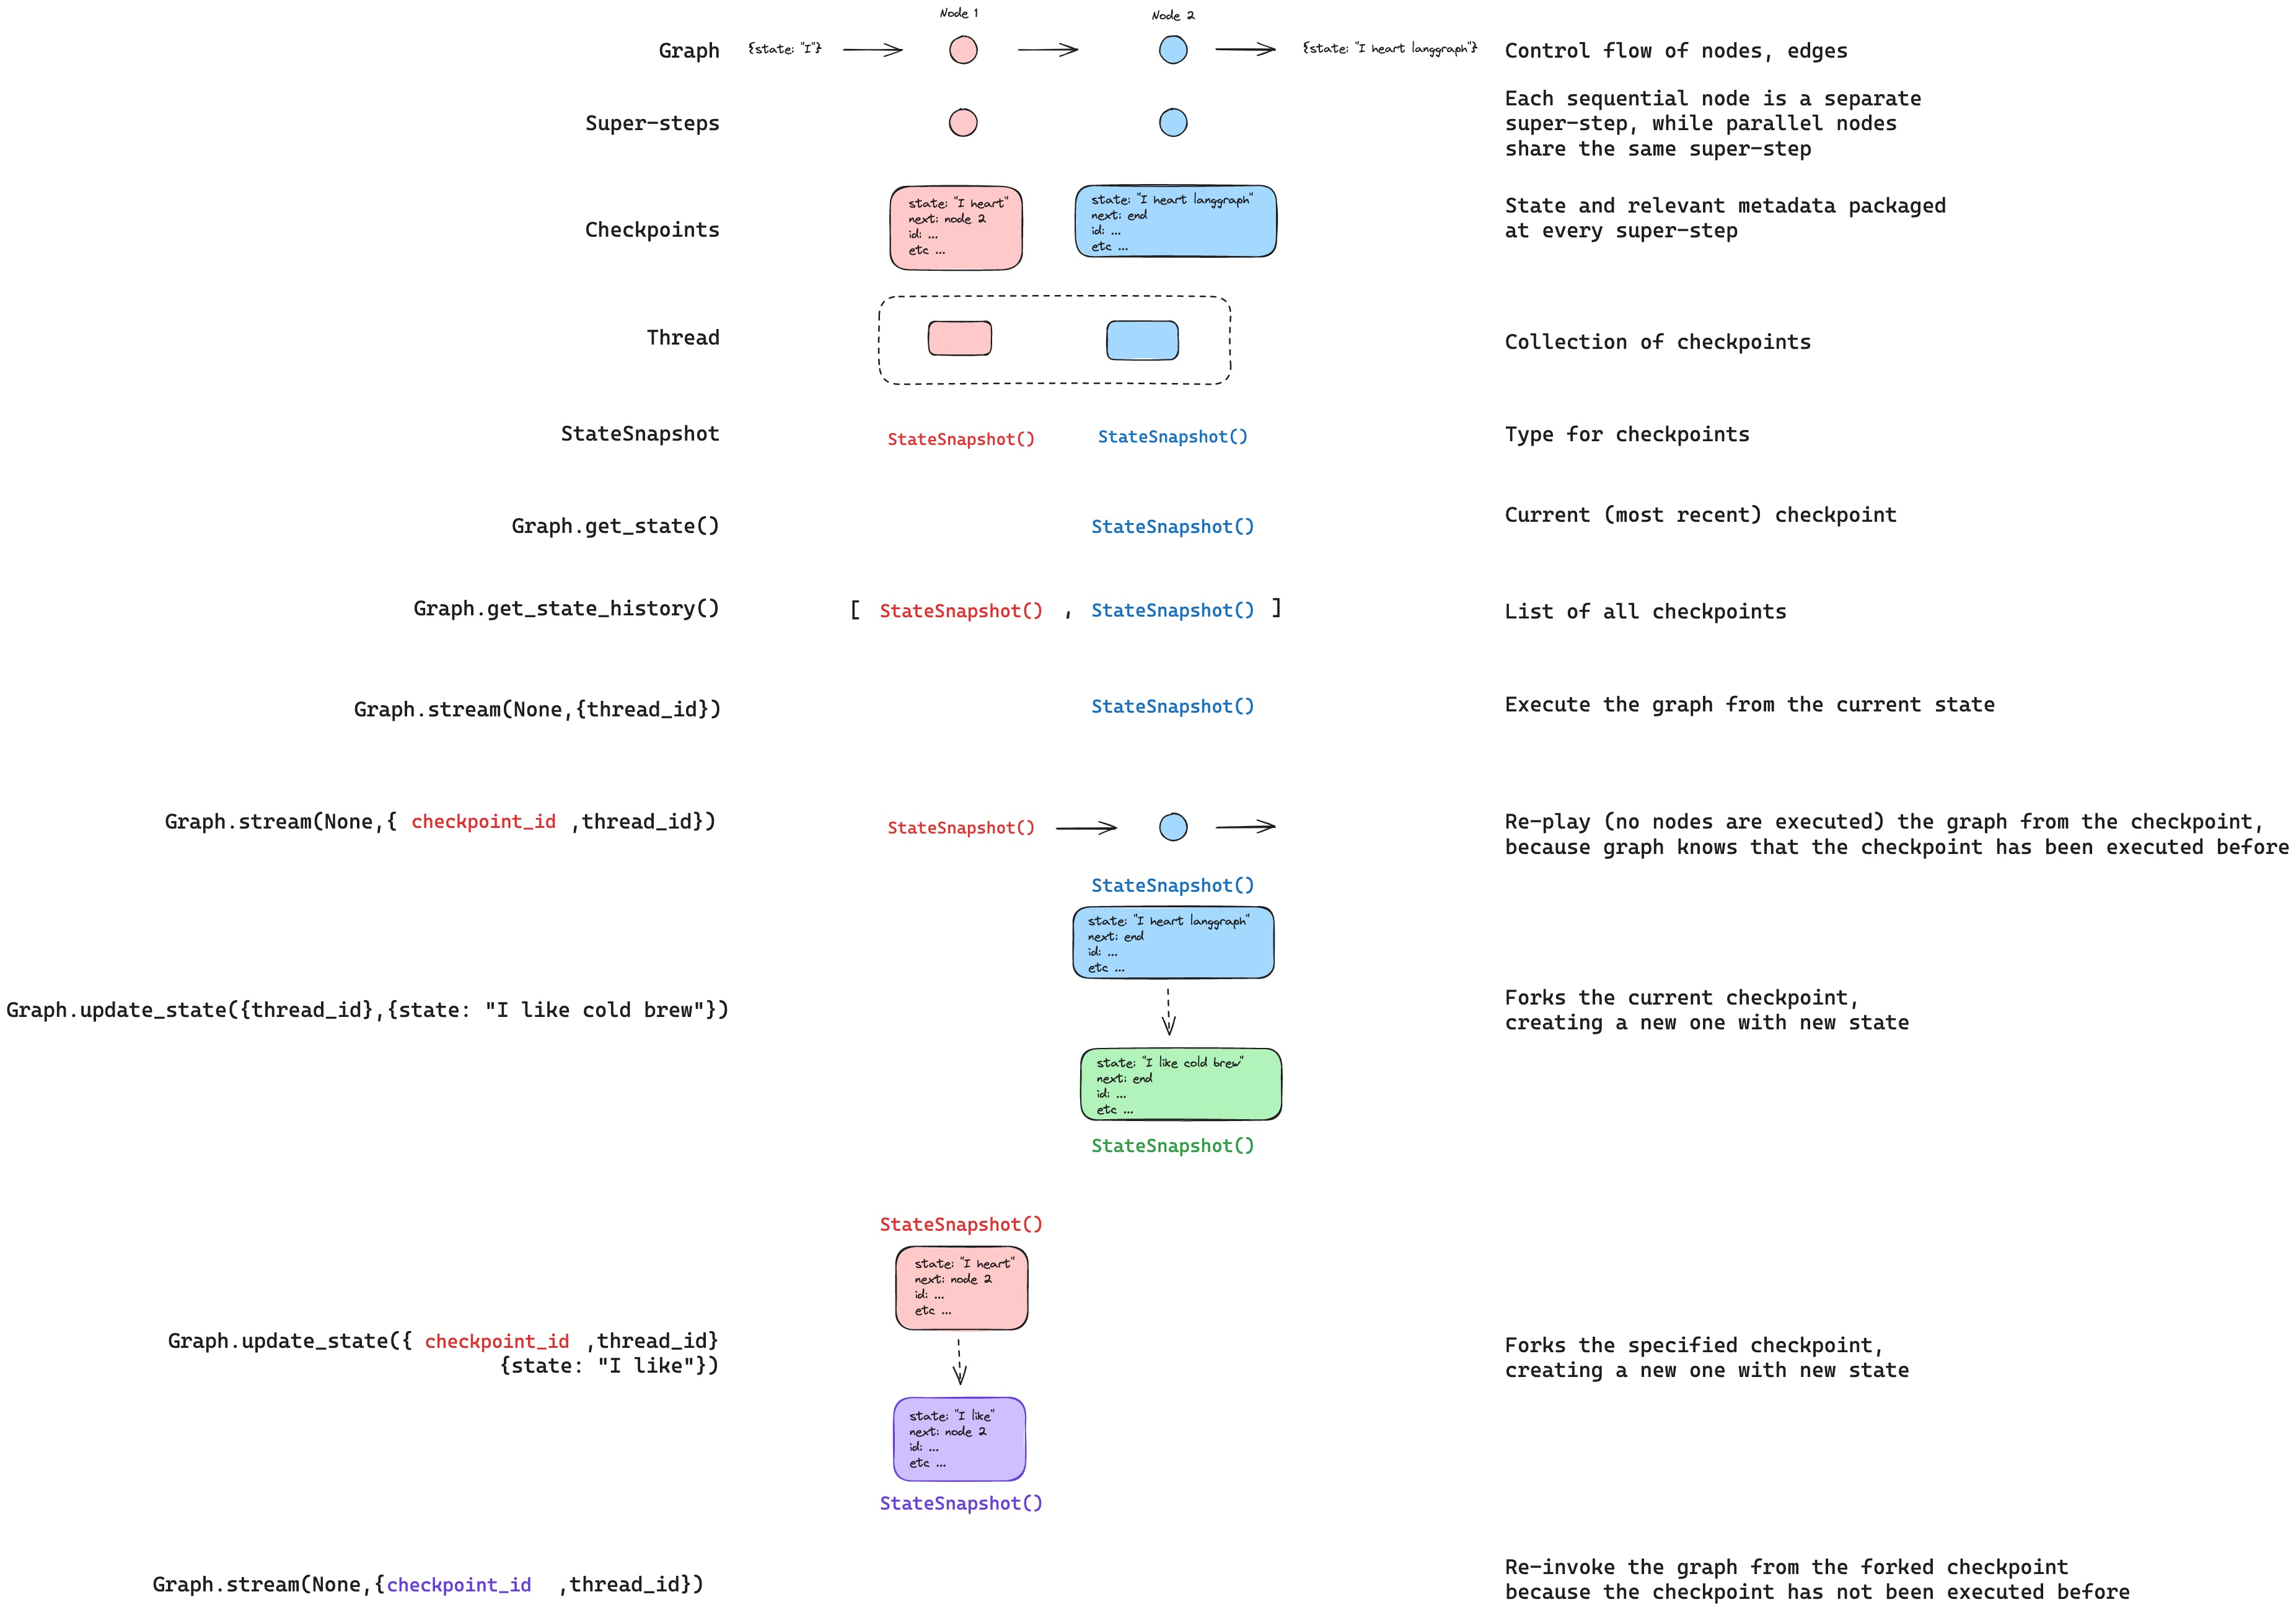
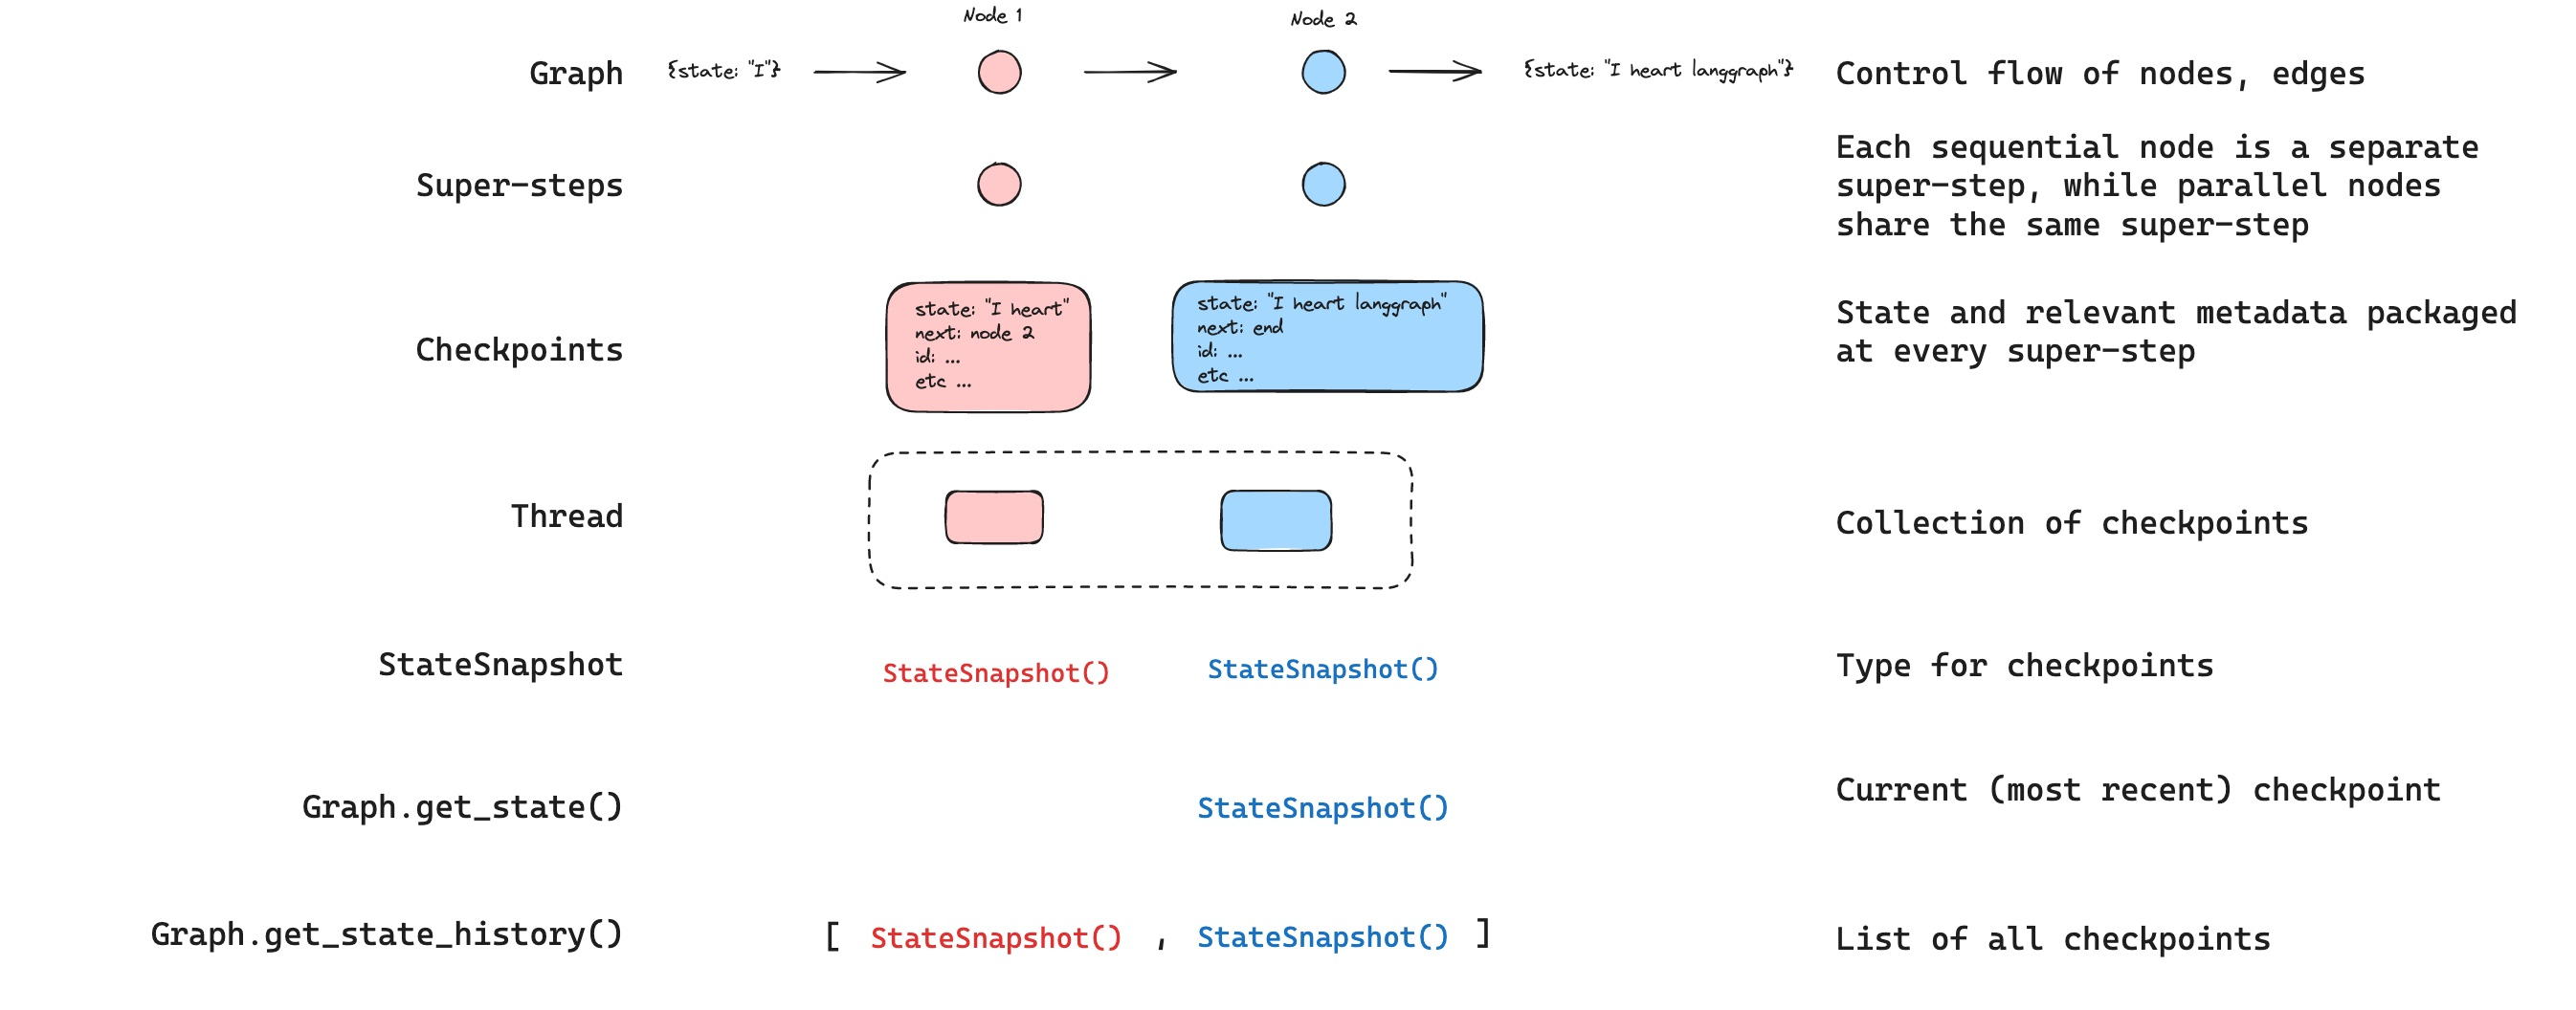

In [80]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='27d93cef-c10e-446b-9479-55f3e262d770'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wytd', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 311, 'total_tokens': 336, 'completion_time': 0.125, 'prompt_time': 0.016861808, 'queue_time': 0.237910535, 'total_time': 0.141861808}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dcb253fd-4f13-454b-b8d5-27ce61daabf5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_wytd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 311, 'output_tokens': 25, 'total_tokens': 336})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1effb22

In [81]:
for event in tool_graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_wytd)
 Call ID: call_wytd
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Edit Human Feedback

In [117]:
tool_graph.update_state(config, {"messages":[HumanMessage(content="No, Acutally multiply 3 and 4!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1effb279-2eeb-67c1-8002-13ba7e71f7db'}}

In [118]:
new_state = tool_graph.get_state(config).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_atq4)
 Call ID: call_atq4
  Args:
    a: 2
    b: 3
================================ Human Message =================================

No, Acutally multiply 3 and 4!


In [120]:
for event in tool_graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, Acutally multiply 3 and 4!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_z910)
 Call ID: call_z910
  Args:
    a: 3
    b: 4


In [121]:
state = tool_graph.get_state(config)
state.next

('tools',)

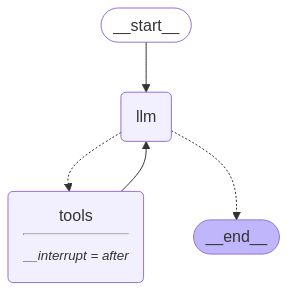

In [15]:
## Memory in Agents using MemorySaver
memory=MemorySaver()

## Graph
builder=StateGraph(MessagesState)
builder.add_node("llm",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm")
builder.add_conditional_edges(
    "llm",
    ## If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    ## IF the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","llm")
## Human in the loop
tool_graph=builder.compile(interrupt_after=["tools"], checkpointer=memory)

## display
display(Image(tool_graph.get_graph().draw_mermaid_png()))

In [16]:
intial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config={'configurable':{'thread_id':'2'}}

In [17]:
for event in tool_graph.stream(intial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1ysb)
 Call ID: call_1ysb
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [18]:
state = tool_graph.get_state(config)
state.next

('llm',)

In [19]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='1f2f7f09-67e4-4d1b-9fc0-377a175c68ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1ysb', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 311, 'total_tokens': 336, 'completion_time': 0.125, 'prompt_time': 0.018250183, 'queue_time': 0.243720299, 'total_time': 0.143250183}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-662a7d9c-1c51-45c2-8bc5-3ccb93158f27-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_1ysb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 311, 'output_tokens': 25, 'total_tokens': 336}), ToolMessage(content='6', name='multiply', id='f09dd98c-1331-4da5-b8cb-dad5e9637538', tool_call_id='call_1ysb

In [20]:
for event in tool_graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


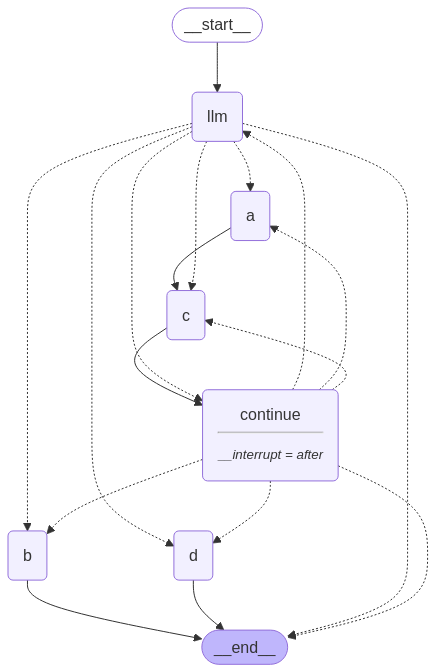

In [21]:
import random
from typing import TypedDict, Sequence, Annotated
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field

class ActionResult[T](BaseModel):
    code: Annotated[int, Field(description='code')]
    data: Annotated[T, Field(description='data')]
    msg: Annotated[str, Field(description='msg')]

class State(TypedDict):
    name: str
    next: str
    data: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


def fa() -> ActionResult[str]:
    x = random.randint(1, 10)
    print(x)
    # if x > 6:
    #     return ActionResult(code=0, data='test', msg='')
    # else:
    #     return ActionResult(code=1, data='', msg='error')
    return ActionResult(code=0, data='test', msg='')

def llm(state: State) -> dict:
    res = fa()
    if res.code == 0:
        return {'next': 'a', 'data': res.data}
    else:
        return {'next': 'b'}

def cond(state: State) -> str:
    return state.get('next')

def a(state: State) -> dict:
    print('a')
    return {'messages': [AIMessage(content=state.get('data'))]}

def b(state: State) -> dict:
    print('b')
    return {'messages': [AIMessage(content='node b')]}

def c(state: State) -> dict:
    print('c')
    return {'messages': [AIMessage(content='node c')]}

def d(state: State) -> dict:
    print('d')
    return {'messages': [AIMessage(content='node d')]}

def continue_exec(state: State) -> dict:
    print('continue? A: continue B: End')
    return {'messages': [AIMessage(content='continue? A: continue B: End')]}

def continue_judge(state: State) -> str:
    msg = state.get('messages')[-1].content
    if msg == 'A':
        return 'd'
    else:
        return END

graph = StateGraph(State)
graph.add_node('llm', llm)
graph.add_node('a', a)
graph.add_node('b', b)
graph.add_node('c', c)
graph.add_node('continue', continue_exec)
graph.add_node('d', d)
graph.add_conditional_edges('llm', cond)
graph.add_edge('a', 'c')
graph.add_edge('c', 'continue')
graph.add_conditional_edges('continue', continue_judge)
graph.add_edge('b', END)
graph.add_edge('d', END)
graph.set_entry_point('llm')

memory = MemorySaver()
app = graph.compile(checkpointer=memory, interrupt_after=['continue'])
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
cfg = {"configurable": {"thread_id": "thread-1"}}
res = app.invoke(State(name='xxx', next='', data='', messages=[]), cfg)
print(res)

3
a
c
continue? A: continue B: End
{'name': 'xxx', 'next': 'a', 'data': 'test', 'messages': [AIMessage(content='test', additional_kwargs={}, response_metadata={}, id='6607fd35-2d69-45bb-afc8-a6b59f96c89f'), AIMessage(content='node c', additional_kwargs={}, response_metadata={}, id='c04665ab-ebd3-4ce1-b3bc-85f85aeaa936'), AIMessage(content='continue? A: continue B: End', additional_kwargs={}, response_metadata={}, id='b46a1085-a819-458b-b146-91a188298c2e')]}


In [25]:
snapshot = app.get_state({"configurable": {"thread_id": "thread-1"}})
snapshot.values['messages'].append(HumanMessage(content='A'))
app.update_state(cfg, snapshot.values)
r = app.invoke(None, config=cfg, stream_mode='values')
print(r)

{'name': 'xxx', 'next': 'a', 'data': 'test', 'messages': [AIMessage(content='test', additional_kwargs={}, response_metadata={}, id='6607fd35-2d69-45bb-afc8-a6b59f96c89f'), AIMessage(content='node c', additional_kwargs={}, response_metadata={}, id='c04665ab-ebd3-4ce1-b3bc-85f85aeaa936'), AIMessage(content='continue? A: continue B: End', additional_kwargs={}, response_metadata={}, id='b46a1085-a819-458b-b146-91a188298c2e'), HumanMessage(content='A', additional_kwargs={}, response_metadata={}, id='7b5f2e8e-2a46-4e60-9480-425a9a3b718c'), AIMessage(content='node d', additional_kwargs={}, response_metadata={}, id='3e9248d6-382e-4bab-be0e-b8a37928d56a'), HumanMessage(content='A', additional_kwargs={}, response_metadata={}, id='1c5da6d8-6c26-4054-9659-64edd118c811')]}


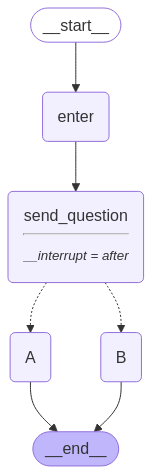

In [26]:
from collections.abc import Callable
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import AnyMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, add_messages


class State(TypedDict, total=False):
    messages: Annotated[list[AnyMessage], add_messages]
    reply: str


def ai_message(msg: str) -> Callable[..., State]:
    def handler(_: State) -> State:
        return {"messages": [("ai", msg)]}

    return handler


def route(state: State) -> Literal["A", "B"]:
    print("This is the ROUTE function")
    # This will be printed twice
    # The first one is before `interrupt_after` and the second one is in `update`
    return "A" if state["reply"] == "A" else "B"


graph_builder = StateGraph(State)
graph_builder.set_entry_point("enter")
# It must be initialized first; otherwise, an KeyError will occur when the route function tries to get 'reply'.
graph_builder.add_node("enter", lambda _: {"reply": ""})
graph_builder.add_node("send_question", ai_message("Do you want to go to A or B?"))
graph_builder.add_node("A", ai_message("You are in A"))
graph_builder.add_node("B", ai_message("You are in B"))

graph_builder.add_edge("enter", "send_question")
graph_builder.add_conditional_edges("send_question", route)
graph_builder.add_edge("A", END)
graph_builder.add_edge("B", END)
memory = MemorySaver()
app = graph_builder.compile(checkpointer=memory, interrupt_after=["send_question"])
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
def print_divider(text: str) -> None:
    print("=" * 20 + text + "=" * 20)


thread_config = {"configurable": {"thread_id": "1"}}
print(app.invoke({"messages": []}, thread_config))

print_divider("interrupt_after")
print("next_node is ", app.get_state(thread_config).next)  # it will print ('B', )

This is the ROUTE function
{'messages': [AIMessage(content='Do you want to go to A or B?', additional_kwargs={}, response_metadata={}, id='f3b24a6d-f4ae-4a43-a075-c94475a1d72b')], 'reply': ''}
====================interrupt_after====================
next_node is  ('B',)


In [28]:
print_divider("update")
app.update_state(thread_config, {"reply": "A"})
print(app.invoke(None, thread_config))

====================update====================
This is the ROUTE function
{'messages': [AIMessage(content='Do you want to go to A or B?', additional_kwargs={}, response_metadata={}, id='f3b24a6d-f4ae-4a43-a075-c94475a1d72b'), AIMessage(content='You are in A', additional_kwargs={}, response_metadata={}, id='bdbb5c62-a902-45e4-946e-fc565a2c8d36')], 'reply': 'A'}


In [31]:
for event in tool_graph.stream(None, config, stream_mode="values"):
    print(event)
    print("\n")

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='1f2f7f09-67e4-4d1b-9fc0-377a175c68ca'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1ysb', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 311, 'total_tokens': 336, 'completion_time': 0.125, 'prompt_time': 0.018250183, 'queue_time': 0.243720299, 'total_time': 0.143250183}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-662a7d9c-1c51-45c2-8bc5-3ccb93158f27-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_1ysb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 311, 'output_tokens': 25, 'total_tokens': 336}), ToolMessage(content='6', name='multiply', id='f09dd98c-1331-4da5-b8cb-dad5e9637538', tool_call_id='call_1ysb'), AIMessage(content

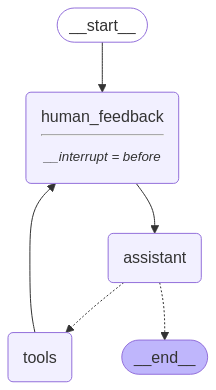

In [123]:
## System message
sys_msg=SystemMessage(content='You are a helpfull assistant tasked with preforming arthmetic on a set of inputs.')

## no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

## Assistant node
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state['messages'])]}

## Graph
builder = StateGraph(MessagesState)

## Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",human_feedback)

## Define edges
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools","human_feedback")

memory=MemorySaver()

## Compile
graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

## Display
display(Image(graph.get_graph().draw_mermaid_png()))

In [124]:
## Input
intial_input = {"messages": "Multiply 2 and 3"}

## Thread
thread = {"configurable":{"thread_id":"3"}}

## Run the graph intill the first interruption
for event in graph.stream(intial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
## get the user input
user_input = input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input} )

## Run the graph intill the first interruption
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

no please multiply 3 by 14
================================== Ai Message ==================================
Tool Calls:
  multiply (call_mgj6)
 Call ID: call_mgj6
  Args:
    a: 3
    b: 14
================================= Tool Message =================================
Name: multiply

42
